In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
density = 1026 #Water density - kg/m3
c_p = 3850 #Specific heat of salt water - J/kgC
seconds = 7*24*60*60 #Time in a week - seconds
mlotst_equator = 21.95173968 # Mixed layer depth at equator - m

In [3]:
def white_noise(sigma):
    """
    Define white noise using a normal distribution
    
    """
    mean = 0
    std = sigma
    
    return np.random.normal(mean, std)

In [6]:
def lag_regress(params, years, lagint):
    lambda_t = params['lambda_t'] # TOA feedback
    lambda_h = params['lambda_h'] # Advection feedback
    lambda_o = params['lambda_o'] # Ocean feedback
    sigma_a = params['sigma_a']   # Variance of atmospheric forcing
    sigma_o = params['sigma_o']   # Variance of oceanic forcing
    
    Nt = 52*years # Number of timesteps - weekly [weeks]
    dt = 60*60*24*7 # Timestep - week [s]
    
    np.random.seed(4)
    
    T = np.zeros(Nt+1) # Temperature array over time [K]
    
    F_o = white_noise(sigma_o)
    Q_toa = np.zeros(Nt)
    Q_oce = np.zeros(Nt)
    for t in range(1,Nt):
        Q_oce[t] = -lambda_o*T[t] + white_noise(sigma_o) 
        Q_toa[t] = -lambda_t*T[t] - lambda_h*T[t] + white_noise(sigma_a)
        T[t+1] = T[t] + (dt/(c_p*density*mlotst_equator))*(Q_toa[t] + Q_oce[t])
    
    lag_series = np.arange(-lagint,lagint,1)
    lagresponse_toa = np.zeros(len(lag_series))
    lagresponse_oce = np.zeros(len(lag_series))
    i = 0
    for lag in lag_series:
        if lag < 0:
            laggedtoa = Q_toa[0:lag]
            laggedoce = Q_oce[0:lag]
            T_trunc = np.roll(T, lag)[0:lag-1]
        elif lag == 0:
            laggedtoa = Q_toa
            laggedoce = Q_oce
            T_trunc = T[:-1]
        elif lag > 0:    
            laggedoce = np.roll(Q_oce,-lag)[0:-lag]
            laggedtoa = np.roll(Q_toa,-lag)[0:-lag]
            T_trunc = T[0:-lag-1]
        lagresponse_toa[i] = np.polyfit(T_trunc, laggedtoa, deg=1)[0]
        lagresponse_oce[i] = np.polyfit(T_trunc, laggedoce, deg=1)[0]
        i += 1
        
    return lagresponse_toa, lagresponse_oce, lag_series

In [8]:
# Analytical solution

def analytical(params, lagint):
    lambda_o = params['lambda_o'] # Ocean feedback
    lambda_t = params['lambda_t'] # TOA feedback
    lambda_h = params['lambda_h'] # Advection feedback
    sigma_a = params['sigma_a']   # Variance of atmospheric forcing
    sigma_o = params['sigma_o']   # Variance of oceanic forcing
    
    dt = 60*60*24*7 # Timestep - week [s]
        
    lag_series = np.arange(-lagint,lagint,1)*dt
        
    c = c_p*density*mlotst_equator # Heat capacity
    
    w_0 = (lambda_t + lambda_h + lambda_o)/c

    eq_secondhalf = (lambda_t + lambda_h + lambda_o) * 2/(sigma_a**2+sigma_o**2) * np.exp(-w_0*abs(lag_series))
    
    for i in range(len(eq_secondhalf)):
        if lag_series[i]>0:
            eq_secondhalf[i] = 0
        else:
            eq_secondhalf[i] = eq_secondhalf[i]
        
    # r_analytical = -np.exp(-lambda_a*abs(lag_series*dt)/c)*lambda_a
    r_atmos = -(lambda_t + lambda_h)*np.exp(-w_0*abs(lag_series)) + (eq_secondhalf)*sigma_a**2
    r_ocean = -lambda_o*np.exp(-w_0*abs(lag_series)) + (eq_secondhalf)*sigma_o**2

    return r_atmos, r_ocean

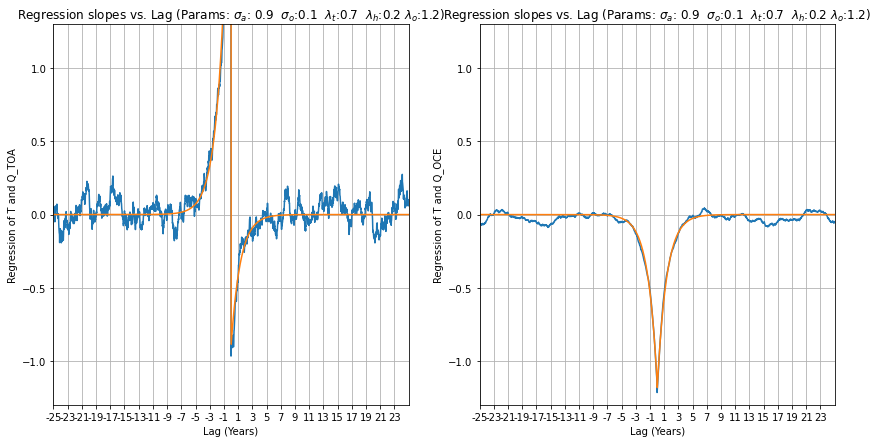

In [12]:
# sigma_a > sigma_o
params = {}
params['lambda_t'] = 0.7
params['lambda_h'] = 0.2
params['lambda_o'] = 1.2
params['sigma_a'] = 0.9
params['sigma_o'] = 0.1
years = 1000
lagint = 52*25

lagresponse_toa, lagresponse_oce, lagseries = lag_regress(params, years, lagint)
analytic_atmos, analytic_ocean = analytical(params, lagint)

plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse_toa)
ax.plot(lagseries, analytic_atmos)
ax.set_ylim(-1.3,1.3)
ax.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_t$:' + str(params['lambda_t']) +
                                              r'  $\lambda_h$:' + str(params['lambda_h']) + r' $\lambda_o$:' + 
                                              str(params['lambda_o']) + ')')
ax.grid()

# Ocean
ax2.plot(lagseries, lagresponse_oce)
ax2.plot(lagseries, analytic_ocean)
ax2.set_ylim(-1.3,1.3)
ax2.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
ax2.set_xlim(-25*52,25*52)
ax2.set_xlabel('Lag (Years)')
ax2.set_ylabel('Regression of T and Q_OCE')
ax2.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_t$:' + str(params['lambda_t']) +
                                              r'  $\lambda_h$:' + str(params['lambda_h'])
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')

#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()